# Solve fluid diffusion equation in a square domain with imposed flux on the bottom left corner (point injection)

In [1]:
import numpy as np
from mpi4py import MPI
import pyvista
import ufl
import dolfinx 

from dolfinx import fem, plot
from dolfinx.io import XDMFFile
from dolfinx.fem import FunctionSpace, Constant, Function

from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

## Read the mesh

In [2]:
# Read the mesh
with XDMFFile(MPI.COMM_WORLD, "mesh_square/square_mesh.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    cell_tags = xdmf.read_meshtags(mesh, name="Grid")
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)

with XDMFFile(MPI.COMM_WORLD, "mesh_square/square_facet_mesh.xdmf", "r") as xdmf:
    facet_tags = xdmf.read_meshtags(mesh, name="Grid")

## Plot the mesh

In [3]:
topology, cell_types, geometry = plot.create_vtk_mesh(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

pyvista.set_jupyter_backend("pythreejs")

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

## Define temporal parameters

In [4]:
t = 0 # Start time
T = 80.0 # Final time
num_steps = 40     
dt = T / num_steps # time step size

## Finite element function space

In [5]:
V = FunctionSpace(mesh, ("CG", 1))  # Lagrange element and and linear elements (degree 1)

## Set initial conditions

In [6]:
# by default all values are 0 if not initialized
p_n = Function(V)
p_n.name = "p_n"

## Boundary conditions

In [7]:
# DIRICHLET: p=0 on all Dirichlet BC (sides 2 and 4)
boundary_dofs = fem.locate_dofs_topological(V, mesh.topology.dim-1, facet_tags.indices[(facet_tags.values == 3) | (facet_tags.values == 5)])
bc = fem.dirichletbc(ScalarType(0), boundary_dofs, V)

# NEUMANN: 0 flux on sides 1 and 3

## Time-dependent output

In [8]:
p_h = p_n.copy()
p_h.name = "p_h"

## Trial and test functions

In [9]:
p, r = ufl.TrialFunction(V), ufl.TestFunction(V)

## Source term

In [10]:
# see this discussion to understand how to implement source points: https://fenicsproject.discourse.group/t/dirac-delta-distribution-dolfinx/7532/3

dofs = dolfinx.fem.locate_dofs_geometrical(V,  lambda x: np.isclose(x.T, [0, 0, 0]).all(axis=1))
# or you could also use:
#def on_A(x):
#    return np.isclose(x[0], 0) & np.isclose(x[1], 0)
#dofs = dolfinx.fem.locate_dofs_geometrical(V,  on_A)

# p_h.x.array[dofs] = 10
# CAREFUL: line above is false as we impose a constant flux on point A, not a constant pressure. See the loop for more info (we add the source term to vector b).

## Variational problem

As the test function is zero on the boundary integrals over the Dirichlet boundary, we can integrate g*v*ds over the entire boundary.

In [11]:
#S = fem.Constant(mesh, ScalarType(1))
#kappa = fem.Constant(mesh, ScalarType(1))

S = 1 #1675
kappa = 1 #100
c = kappa/S

In [12]:
a = S * p * r * ufl.dx + dt * kappa * ufl.dot(ufl.grad(p), ufl.grad(r)) * ufl.dx 
L = (S * p_n) * r * ufl.dx

# note: here we don't give f in the L term as it is a pointsource and not a function over the domain

## Preparation of linear algebra structures for time dependent problems

In [13]:
bilinear_form = fem.form(a)
linear_form = fem.form(L)

In [14]:
# bilinear_form (a) isn't time dependant so we can assemble it once (we could do the same for the integral of the Neumann term as the flux is contant, but for now let's stay like that)
A = fem.petsc.assemble_matrix(bilinear_form, bcs=[bc])
A.assemble()
b = fem.petsc.create_vector(linear_form)

## Linear solver

In [15]:
# here matrix A is already assembled so we don't need to use petsc.LinearProblem like in tuto1
solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

In [16]:
import pyvista
pyvista.set_jupyter_backend("ipygany")

grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(V))

def plot_function(t, uh):
    """
    Create a figure of the concentration uh warped visualized in 3D at timet step t.
    """
    p = pyvista.Plotter()
    # Update point values on pyvista grid
    grid.point_data[f"u({t})"] = uh.x.array.real
    # Warp mesh by point values
    warped = grid.warp_by_scalar(f"u({t})", factor=1.5)

    # Add mesh to plotter and visualize in notebook or save as figure
    actor = p.add_mesh(warped)
    if not pyvista.OFF_SCREEN:
        p.show()
    else:
        pyvista.start_xvfb()
        figure_as_array = p.screenshot(f"diffusion_{t:.2f}.png")
        # Clear plotter for next plot
        p.remove_actor(actor)
plot_function(0, p_h)

AppLayout(children=(VBox(children=(HTML(value='<h3>u(0)</h3>'), Dropdown(description='Colormap:', options={'Br…

## Update the solution and right hand side per time step 

In [17]:
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    fem.petsc.assemble_vector(b, linear_form)
    
    # Apply Dirichlet boundary condition to the vector
    fem.petsc.apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, [bc])
    # add source point to vector b
    b.array[dofs] = 10*dt
        
    # Solve linear problem
    solver.solve(b, p_h.vector)
    p_h.x.scatter_forward()

    # Update solution at previous time step (u_n)
    p_n.x.array[:] = p_h.x.array
    
    # Plot every 15th time step
    if i % 15 == 0:
        plot_function(t, p_h)

AppLayout(children=(VBox(children=(HTML(value='<h3>u(2.0)</h3>'), Dropdown(description='Colormap:', options={'…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(32.0)</h3>'), Dropdown(description='Colormap:', options={…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(62.0)</h3>'), Dropdown(description='Colormap:', options={…

## Post-processing

In [18]:
from scipy.special import exp1 
import matplotlib.pyplot as plt

In [19]:
# analytical solution of 2D diffusion
def p_analytical(r, t):
    source = 10*4 # *4 because of double symetry
    return source*1/(4*np.pi*kappa)*exp1(r**2/(4*c*t))

In [20]:
# look for the pressures on L_bottom
r_bottom = mesh.geometry.x[mesh.geometry.x[:,1]==0][:,0]
p_bottom = p_h.x.array[mesh.geometry.x[:,1]==0]
# sort these pressures according to the radial distance from point A 
index_order = np.argsort(r_bottom)
r_numerical = r_bottom[index_order]
p_numerical = p_bottom[index_order]

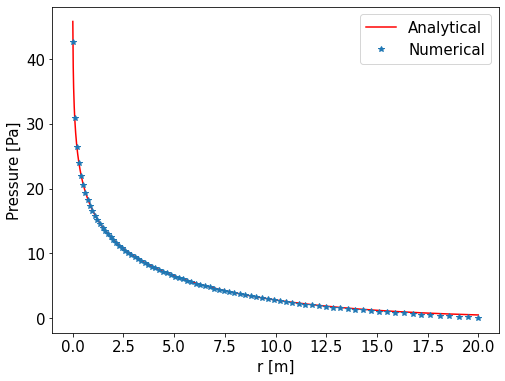

In [21]:
# plot with matplotlib

# x axis for analytical solution
x = np.arange(0., 20., 0.01)

# plot
plt.figure(figsize=(8, 6))
plt.plot(x, p_analytical(x, t), 'r-', r_numerical, p_numerical, '*')
plt.legend(['Analytical', 'Numerical'], loc='upper right', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('r [m]', fontsize=15)
plt.ylabel('Pressure [Pa]', fontsize=15) 
plt.savefig("point_injection.png", )
plt.show()